<h1 style="font-family: Verdana; font-size: 28px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; background-color: #CCCCFF; color: black;"><center><br>[Data Augmentation] 👀: Gaussian-Laplacian Pyramid Blending </center></h1>
                                                      
<center><img src = "https://drive.google.com/uc?id=1pbIvjTlhGywfhiMTqcsdOB5LSHlklM90"/></center>   

<h5 style="text-align: center; font-family: Verdana; font-size: 12px; font-style: normal; font-weight: bold; text-decoration: None; text-transform: none; letter-spacing: 1px; color: black; background-color: #ffffff;">CREATED BY: NGHI HUYNH* and YUAN HONG</h5>

<p id="toc"></p>
<h2 class="list-group-item list-group-item-action active" data-toggle="list" style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; background-color: #CCCCFF; color: black;" role="tab" aria-controls="home"><center><br>CONTENTS</center></h2>

<h3 style="text-indent: 10vw; font-family: Verdana; font-size: 16px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: black; background-color: #ffffff;"><a href="#motive">0&nbsp;&nbsp;&nbsp;&nbsp;MOTIVATION</a></h3>

---

<h3 style="text-indent: 10vw; font-family: Verdana; font-size: 16px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: black; background-color: #ffffff;"><a href="#blending">1&nbsp;&nbsp;&nbsp;&nbsp;GAUSSIAN-LAPLACIAN PYRAMID BLENDING</a></h3>

---

<h3 style="text-indent: 10vw; font-family: Verdana; font-size: 16px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: black; background-color: #ffffff;"><a href="#demo">2&nbsp;&nbsp;&nbsp;&nbsp;DEMO</a></h3>

---


<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:#F08080; border:0; color:black' role="tab" aria-controls="home"><center><br>If you find this notebook useful, do give me an upvote, it motivates me a lot.<br><br> This notebook is still a work in progress. Keep checking for further developments!😊</center></h3>

<a id="imports"></a>

<h2 style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; background-color: #CCCCFF; color: black;" id="motive"><left><br>&nbsp;0. MOTIVATION <a href="#toc">&#10514;</a><br></left> </h2>

While working on this challenge, I realize some problems that we are facing. Thus, I want to suggest a potential solution for those problems. I also create a discussion thread: [Data Augmentation: Gaussian-Laplacian Pyramid Blending](https://www.kaggle.com/competitions/hubmap-organ-segmentation/discussion/341235) to follow up.

There are **3** main problems:

1. **[Stain Variations](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5374099/)**: 
    * Histopathological images (HIs) stained with **DAB + H** based on immunohistochemistry (IHC) technique leads to inter-batch variations. In DAB staining, brown chromogen reveals protein expression, while hematoxylin is for tissue counterstaining.

    * HIs stained with **H&E**: hematoxylin highlights the nuclei with a blueish color, and eosin highlights the cytoplasm and extracellular matrix in pink
    
    * HIs stained with **PAS**: magenta to red color for PAS positive material, blue color for cell nuclei
    
    ![](https://drive.google.com/uc?id=1ZDlg8iveb1ZI92oHvwtrppsCCR3HmvMn)
    
    * **[Figure 1](https://www.ncbi.nlm.nih.gov/core/lw/2.0/html/tileshop_pmc/tileshop_pmc_inline.html?title=Click%20on%20image%20to%20zoom&p=PMC3&id=5374099_AHC16025f02.jpg)**: A-E (left-right, top-bottom): Results of hematoxylin and eosin (H&E), periodic acid-Schiff (PAS), and immunohistochemical staining (3,3'-diaminobenzidine and hematoxylin, DAB&H) of renal tissue from control rats. **A.** H&E staining. D, distal tubules; G, glomerulus; P, proximal tubules. **B.** PAS staining. Arrows, brush borders; BM, tubular basement membranes; D, distal tubules; P, proximal tubules. **C.** iNOS immunostaining (DAB&H). **D.** BAX immunostaining (DAB&H). **E.** VDR immunostaining (DAB&H).

    => All techniques commonly face differences in intensity, saturation, and hue in the HIs. Color variations may introduce a bias to ML algorithms.

2. **Data Imbalance**: DL models require very large datasets for training to avoid overfitting the models. We have some class imbalance for **spleen**, **lung** and **large intestine**. HI datasets are usually small due to expensive labeling. Data imbalance leads to impacts on supervised learning algorithms

    ![](https://drive.google.com/uc?id=1Ah7dIzDK5MNvrQrPZoSYGLwBFo9pWy4V)


3. **Inter- and Intra-Class Variability**: HIs are not only different between classes, but they are also different within classes

    ![](https://drive.google.com/uc?id=12S_xNSa9g5MKapKj-TK6i7Ar_KdHU6oZ)

=> Data augmentation has been actively used to circumvent these problems. In this notebook, I'll apply an image blending approach using the **Gaussian-Laplacian pyramid blending** technique to generate more data within classes. This technique aims to improve the generalization ability of ML algorithms dealing with HIs.


<a id="blending"></a>

<h2 style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; background-color: #CCCCFF; color: black;" id="blending"><left><br>&nbsp;1. Gaussian-Laplacian Pyramid Blending <a href="#toc">&#10514;</a><br></left> </h2>

# Background

### Objective: 
Given 2 histopathological images within the same class, and an image mask, blend the images in a seamless way

<center><img src = "https://drive.google.com/uc?id=1JUiPlQee5lpYf1JLMiz1A8BrRO2HoNHD"></center> 

### Algorithm Overview:

**1.** Build **Laplacian** pyramids $LA$ and $LB$ from images A and B

**2.** Build a **Gaussian** pyramid $GR$ from selected region R (mask that says which pixels come from left and which from right)

**3.** Form a **combined** pyramid $LS$ from $LA$ and $LB$ using nodes of $GR$ as weights:

 $$LS(i,j) = GR(i,j)*LA(i,j) + (1-GR(i,j))*LB(i,j)$$
    
**4.** Collapse the $LS$ pyramid to get the final blended image

[**Reference**: Data Augmentation for Histopathological Images Based on Gaussian-Laplacian Pyramid Blending](https://arxiv.org/pdf/2002.00072.pdf)

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imageio
import tifffile as tiff
from PIL import Image
import numpy as np
import seaborn as sns
import scipy.signal as sig
from scipy import misc
import matplotlib.pyplot as plt
from scipy import ndimage
import cv2
import imageio
from PIL import Image
import random

# Load Gaussian Kernel

In [2]:
kernel = (1.0/256)*np.array([[1, 4, 6, 4, 1],[4, 16, 24, 16, 4],[6, 24, 36, 24, 6],[4, 16, 24, 16, 4],[1, 4, 6, 4, 1]])

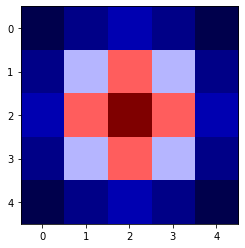

In [3]:
plt.imshow(kernel, cmap='seismic')
plt.show()

In [4]:
kernel.shape

(5, 5)

# Gaussian-Laplacian blending

In [5]:
# https://github.com/twyunting/Laplacian-Pyramids


def interpolate(image):
    """
    Interpolates an image with upsampling rate r = 2
    """
    image_up = np.zeros((2*image.shape[0], 2*image.shape[1]))
    # Upsample
    image_up[::2, ::2] = image
    # Blur (we need to scale this up since the kernel has unit area)
    # (The length and width are both doubled, so the area is quadrupled)
    #return sig.convolve2d(image_up, 4*kernel, 'same')
    return ndimage.filters.convolve(image_up,4*kernel, mode='constant')
                                
def decimate(image):
    """
    Decimates an image with downsampling rate r=2.
    """
    image_blur = ndimage.filters.convolve(image,kernel, mode='constant')
    # Downsample
    return image_blur[::2, ::2]                                
               
                                      
# here is the constructions of pyramids
def pyramids(image):
    """
    Constructs Gaussian and Laplacian pyramids.
    Parameters :
    image  : the original image (i.e. base of the pyramid)
    Returns :
    G   : the Gaussian pyramid
    L   : the Laplacian pyramid
    """
    # Initialize pyramids
    G = [image, ]
    L = []

    # Build the Gaussian pyramid to maximum depth
    while image.shape[0] >= 2 and image.shape[1] >= 2:
        image = decimate(image)
        G.append(image)

   # Build the Laplacian pyramid
    for i in range(len(G) - 1):
        L.append(G[i] - interpolate(G[i + 1]))

    return G[:-1], L


# Build Gaussian pyramid and Laplacian pyramids from images A and B, also mask
# Reference: https://becominghuman.ai/image-blending-using-laplacian-pyramids-2f8e9982077f
def pyramidBlending(A, B, mask):
    [GA, LA] = pyramids(A)
    [GB ,LB] = pyramids(B)
    # Build a Gaussian pyramid GR from selected region R (mask that says which pixels come from left and which from right)
    [Gmask, LMask] = pyramids(mask)
    # Form a combined pyramid LS from LA and LB using nodes of GR as weights
    # Equation: LS(i, j) = GR(I, j)*LA(I, j) + (1-GR(I, j)* LB(I, j))
    # Collapse the LS pyramid to get the final blended image
    blend = []
    for i in range(len(LA)):
        # LS = np.max(Gmask[i])*LA[i] + (1-np.max(Gmask[i]))*LB[i]
        # make sure the color with in 255 (white)
        LS = Gmask[i]/255*LA[i] + (1-Gmask[i]/255)*LB[i]
        blend.append(LS)
    return blend

# reconstruct the pyramids as well as upsampling and add up with each level
def reconstruct(pyramid):
    rows, cols = pyramid[0].shape
    res = np.zeros((rows, cols + cols//2), dtype= np.double)
    # start the smallest pyramid so we need to reverse the order
    revPyramid = pyramid[::-1]
    stack = revPyramid[0]
    # start with the second index
    for i in range(1, len(revPyramid)):
        stack = interpolate(stack) + revPyramid[i] # upsampling simultaneously
    return stack
   
# https://compvisionlab.wordpress.com/2013/05/13/image-blending-using-pyramid/
# Besides pyramid Blending, we need to blend image's color
def colorBlending(img1, img2, mask, organ, i=0):
    # split to 3 basic color, then using pyramidBlending and reconstruct it, respectively
    img1R,img1G,img1B = cv2.split(img1)
    img2R,img2G,img2B = cv2.split(img2)
    # reconstruct each color channel and convert to uint8 to return proper img
    R = reconstruct(pyramidBlending(img1R, img2R, mask))
    G = reconstruct(pyramidBlending(img1G, img2G, mask))
    B = reconstruct(pyramidBlending(img1B, img2B, mask))
    output = cv2.merge((R, G, B))#.astype('uint8')
    imageio.imsave(f"output_{organ}_{i}.png", output)
    img = cv2.imread(f"output_{organ}_{i}.png")
    #img = imageio.v2.imread("output.png")
    return img
    
def Blending_mask(mask1, mask2, mask0, organ, i=0):
#     mask2 = mask2.resize(mask1.size)
    mask00 = imageio.imsave("output_mask.png", mask0)
    mask00 = Image.open("output_mask.png")
    output = Image.composite(mask1, mask2, mask00)
    output = output.save(f"output_mask_{organ}_{i}.png")
    output = Image.open(f"output_mask_{organ}_{i}.png")
    return output


<a id="demo"></a>

<h2 style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; background-color: #CCCCFF; color: black;" id="demo"><left><br>&nbsp;2. DEMO <a href="#toc">&#10514;</a><br></left> </h2>

In [6]:
data_frame = pd.read_csv('../input/hubmap-organ-segmentation/train.csv')

In [7]:
# generate mask
mask0 = np.zeros((512,512))
mask0[:, 256:] = 255

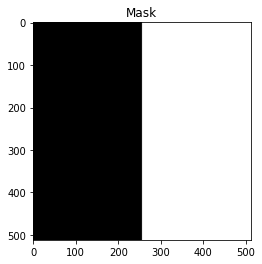

In [8]:
plt.imshow(mask0, cmap='gray')
plt.title('Mask')
plt.show()

## Helper functions

In [9]:
def read_image_mask(df, img_id):
    image = imageio.v2.imread(str('../input/hubmap-organ-512512/train/' f"{img_id}_0000.png"))
    mask = Image.open(str('../input/hubmap-organ-512512/masks/' f"{img_id}_0000.png"))
    return image, mask

def highlight(row):
    df = lambda x: ['background: #CCCCFF' if x.name in row
                        else '' for i in x]
    return df

def plot_blended_img(img_A, img_B, mask, title, organ):
    plt.figure(figsize=(16,9))
    
    plt.subplot(1,4,1)
    plt.imshow(img_A)
    plt.title('Image A')
    
    plt.subplot(1,4,2)
    plt.imshow(img_B)
    plt.title('Image B')
    
    plt.subplot(1,4,3)
    plt.imshow(mask,cmap='gray')
    plt.title('Mask')
    
    plt.subplot(1,4,4)
    blended_img = colorBlending(img_A, img_B, mask, organ=organ)
    plt.imshow(blended_img)
    plt.title('Blended Image')
    
    plt.suptitle(f'{title}', fontsize=20, y=0.75)
    plt.tight_layout()
    plt.show()
    
def plot_blended_mask(mask_A, mask_B, mask, title, organ):
    plt.figure(figsize=(16,9))
    
    plt.subplot(1,4,1)
    plt.imshow(mask_A)
    plt.title('Mask A')
    
    plt.subplot(1,4,2)
    plt.imshow(mask_B)
    plt.title('Mask B')
    
    plt.subplot(1,4,3)
    plt.imshow(mask,cmap='gray')
    plt.title('Mask')
    
    plt.subplot(1,4,4)
    blended_mask = Blending_mask(mask_A, mask_B, mask, organ=organ )
    plt.imshow(blended_mask)
    plt.title('Blended Mask')
    
    plt.suptitle(f'{title}', fontsize=20, y=0.75)
    plt.tight_layout()
    plt.show()
    
def list_ids_organ(df, o):
    """
    Args: 
        df: dataframe
        o: specific organ 
    
    Returns:
        list_ids: list of ids based on organ
    """
    list_ids = list(df.loc[df['organ']==o].id)
    return list_ids

## Metadata

In [10]:
# create an organ dataframe with ids only
organs = {'prostate': [],'spleen': [],'lung': [],'kidney': [],'largeintestine': []}
for organ, ids in organs.items():
    list_organ = list_ids_organ(data_frame, organ)
    ids.append(list_organ)
df_organs = pd.DataFrame.from_dict(organs, orient='index').reset_index()
df_organs.columns = ['organ', 'ids']
df_organs.style.hide_index().apply(highlight([1,3]), axis=1)

organ,ids
prostate,"[10044, 10274, 10666, 10912, 10971, 1184, 12233, 12244, 1229, 13483, 13942, 14396, 14407, 1500, 15706, 15732, 16149, 16609, 16659, 1690, 17143, 17187, 17455, 17828, 18422, 19084, 1955, 19569, 20247, 20428, 20955, 21086, 21155, 2174, 22016, 22059, 22995, 23009, 23640, 23828, 23959, 23961, 24194, 24269, 24961, 25430, 26982, 27471, 28318, 28622, 29213, 29223, 29296, 29307, 29809, 30080, 30294, 30355, 30414, 30424, 30765, 31898, 31958, 32009, 32126, 32412, 32741, 3409, 435, 4639, 4658, 4802, 4944, 5287, 5317, 5785, 5932, 5995, 6120, 6390, 6730, 6794, 737, 7397, 7706, 7902, 8227, 8388, 8638, 8842, 9231, 928, 9358]"
spleen,"[10392, 10610, 10703, 10992, 1123, 11448, 11645, 12026, 12466, 12483, 144, 15551, 18792, 19179, 19360, 19377, 19507, 19997, 2079, 20831, 21358, 22236, 2279, 22953, 24833, 25472, 26664, 27781, 27803, 28126, 28657, 28748, 28963, 29143, 29690, 30201, 3054, 3057, 30581, 31290, 31675, 31733, 32231, 3959, 4404, 5583, 6722, 7169, 8116, 8876, 8894, 9407, 9453]"
lung,"[10488, 11064, 11629, 1220, 12452, 12476, 127, 12827, 13189, 14388, 15067, 15124, 15329, 16564, 1731, 1878, 20563, 23252, 24782, 25516, 25945, 26480, 27232, 2793, 28052, 28189, 28429, 29610, 30084, 30394, 30500, 31139, 31571, 31800, 32151, 4301, 4412, 4776, 5086, 5552, 5777, 686, 7359, 8151, 8231, 8343, 9387, 9450]"
kidney,"[10611, 11497, 1157, 12784, 13034, 13260, 14756, 15005, 15192, 15787, 15860, 16163, 16214, 16216, 16362, 164, 16711, 17422, 18121, 18401, 18426, 18449, 18777, 19048, 19533, 20302, 20440, 20478, 20520, 20794, 21021, 21112, 21129, 21195, 21321, 22035, 22133, 22544, 22718, 22741, 23051, 23243, 2344, 23665, 23760, 23880, 24097, 24100, 24222, 2424, 24241, 2447, 24522, 2500, 25620, 26101, 26174, 2668, 27298, 27350, 27468, 27616, 27879, 28262, 28436, 2874, 28823, 28940, 29238, 2943, 30194, 30224, 30250, 30474, 3083, 30876, 31698, 31709, 32325, 32527, 4066, 4265, 4777, 5099, 5102, 6021, 62, 6318, 660, 6807, 7569, 7970, 8502, 9437, 9445, 9470, 9517, 9769, 9791]"
largeintestine,"[10651, 10892, 11662, 1168, 11890, 12174, 12471, 13396, 13507, 14183, 14674, 15499, 15842, 16728, 16890, 17126, 18445, 1850, 18900, 203, 21039, 21501, 21812, 22310, 23094, 25298, 25641, 25689, 26319, 26780, 26886, 2696, 27128, 27340, 27587, 27861, 28045, 28791, 29180, 29424, 29820, 31406, 31727, 31799, 3303, 351, 4062, 4561, 5832, 6121, 6611, 676, 8222, 8402, 8450, 8752, 9777, 9904]"


## Prostate

In [11]:
df_organs.style.hide_index().apply(highlight([0]), axis=1)

organ,ids
prostate,"[10044, 10274, 10666, 10912, 10971, 1184, 12233, 12244, 1229, 13483, 13942, 14396, 14407, 1500, 15706, 15732, 16149, 16609, 16659, 1690, 17143, 17187, 17455, 17828, 18422, 19084, 1955, 19569, 20247, 20428, 20955, 21086, 21155, 2174, 22016, 22059, 22995, 23009, 23640, 23828, 23959, 23961, 24194, 24269, 24961, 25430, 26982, 27471, 28318, 28622, 29213, 29223, 29296, 29307, 29809, 30080, 30294, 30355, 30414, 30424, 30765, 31898, 31958, 32009, 32126, 32412, 32741, 3409, 435, 4639, 4658, 4802, 4944, 5287, 5317, 5785, 5932, 5995, 6120, 6390, 6730, 6794, 737, 7397, 7706, 7902, 8227, 8388, 8638, 8842, 9231, 928, 9358]"
spleen,"[10392, 10610, 10703, 10992, 1123, 11448, 11645, 12026, 12466, 12483, 144, 15551, 18792, 19179, 19360, 19377, 19507, 19997, 2079, 20831, 21358, 22236, 2279, 22953, 24833, 25472, 26664, 27781, 27803, 28126, 28657, 28748, 28963, 29143, 29690, 30201, 3054, 3057, 30581, 31290, 31675, 31733, 32231, 3959, 4404, 5583, 6722, 7169, 8116, 8876, 8894, 9407, 9453]"
lung,"[10488, 11064, 11629, 1220, 12452, 12476, 127, 12827, 13189, 14388, 15067, 15124, 15329, 16564, 1731, 1878, 20563, 23252, 24782, 25516, 25945, 26480, 27232, 2793, 28052, 28189, 28429, 29610, 30084, 30394, 30500, 31139, 31571, 31800, 32151, 4301, 4412, 4776, 5086, 5552, 5777, 686, 7359, 8151, 8231, 8343, 9387, 9450]"
kidney,"[10611, 11497, 1157, 12784, 13034, 13260, 14756, 15005, 15192, 15787, 15860, 16163, 16214, 16216, 16362, 164, 16711, 17422, 18121, 18401, 18426, 18449, 18777, 19048, 19533, 20302, 20440, 20478, 20520, 20794, 21021, 21112, 21129, 21195, 21321, 22035, 22133, 22544, 22718, 22741, 23051, 23243, 2344, 23665, 23760, 23880, 24097, 24100, 24222, 2424, 24241, 2447, 24522, 2500, 25620, 26101, 26174, 2668, 27298, 27350, 27468, 27616, 27879, 28262, 28436, 2874, 28823, 28940, 29238, 2943, 30194, 30224, 30250, 30474, 3083, 30876, 31698, 31709, 32325, 32527, 4066, 4265, 4777, 5099, 5102, 6021, 62, 6318, 660, 6807, 7569, 7970, 8502, 9437, 9445, 9470, 9517, 9769, 9791]"
largeintestine,"[10651, 10892, 11662, 1168, 11890, 12174, 12471, 13396, 13507, 14183, 14674, 15499, 15842, 16728, 16890, 17126, 18445, 1850, 18900, 203, 21039, 21501, 21812, 22310, 23094, 25298, 25641, 25689, 26319, 26780, 26886, 2696, 27128, 27340, 27587, 27861, 28045, 28791, 29180, 29424, 29820, 31406, 31727, 31799, 3303, 351, 4062, 4561, 5832, 6121, 6611, 676, 8222, 8402, 8450, 8752, 9777, 9904]"


In [12]:
random.seed(10)
random_prostate = random.sample(df_organs.loc[df_organs['organ'] == 'prostate'].ids[0], 2) #.ids[0] -> prostate
img_A, mask_A = read_image_mask(data_frame,random_prostate[0])
img_B, mask_B = read_image_mask(data_frame,random_prostate[1])
img_A.shape, img_B.shape, mask_A.size, mask_B.size

((512, 512, 3), (512, 512, 3), (512, 512), (512, 512))

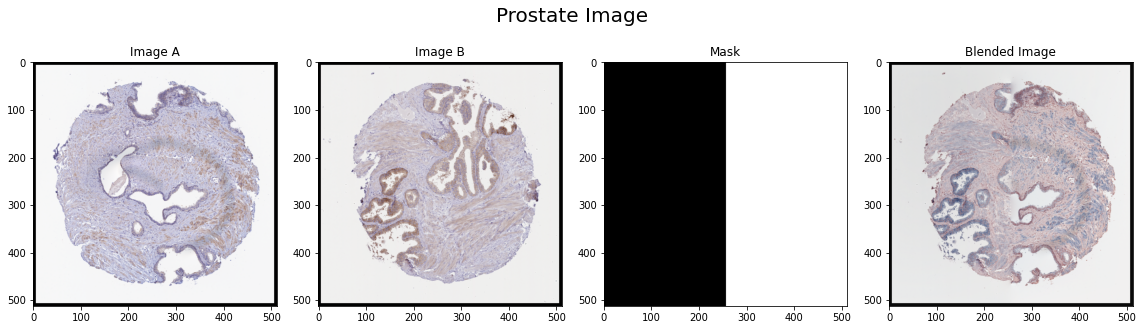

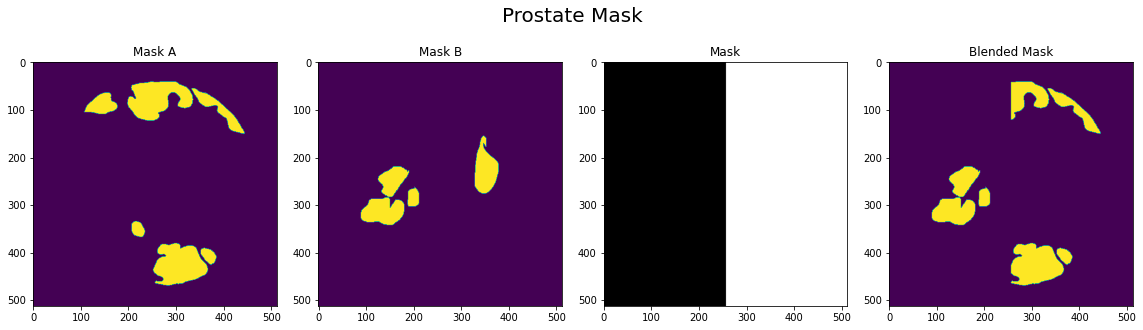

In [13]:
plot_blended_img(img_A, img_B, mask0, 'Prostate Image', 'prostate')
plot_blended_mask(mask_A, mask_B, mask0, 'Prostate Mask', 'prostate')

## Spleen

In [14]:
df_organs.style.hide_index().apply(highlight([1]), axis=1)

organ,ids
prostate,"[10044, 10274, 10666, 10912, 10971, 1184, 12233, 12244, 1229, 13483, 13942, 14396, 14407, 1500, 15706, 15732, 16149, 16609, 16659, 1690, 17143, 17187, 17455, 17828, 18422, 19084, 1955, 19569, 20247, 20428, 20955, 21086, 21155, 2174, 22016, 22059, 22995, 23009, 23640, 23828, 23959, 23961, 24194, 24269, 24961, 25430, 26982, 27471, 28318, 28622, 29213, 29223, 29296, 29307, 29809, 30080, 30294, 30355, 30414, 30424, 30765, 31898, 31958, 32009, 32126, 32412, 32741, 3409, 435, 4639, 4658, 4802, 4944, 5287, 5317, 5785, 5932, 5995, 6120, 6390, 6730, 6794, 737, 7397, 7706, 7902, 8227, 8388, 8638, 8842, 9231, 928, 9358]"
spleen,"[10392, 10610, 10703, 10992, 1123, 11448, 11645, 12026, 12466, 12483, 144, 15551, 18792, 19179, 19360, 19377, 19507, 19997, 2079, 20831, 21358, 22236, 2279, 22953, 24833, 25472, 26664, 27781, 27803, 28126, 28657, 28748, 28963, 29143, 29690, 30201, 3054, 3057, 30581, 31290, 31675, 31733, 32231, 3959, 4404, 5583, 6722, 7169, 8116, 8876, 8894, 9407, 9453]"
lung,"[10488, 11064, 11629, 1220, 12452, 12476, 127, 12827, 13189, 14388, 15067, 15124, 15329, 16564, 1731, 1878, 20563, 23252, 24782, 25516, 25945, 26480, 27232, 2793, 28052, 28189, 28429, 29610, 30084, 30394, 30500, 31139, 31571, 31800, 32151, 4301, 4412, 4776, 5086, 5552, 5777, 686, 7359, 8151, 8231, 8343, 9387, 9450]"
kidney,"[10611, 11497, 1157, 12784, 13034, 13260, 14756, 15005, 15192, 15787, 15860, 16163, 16214, 16216, 16362, 164, 16711, 17422, 18121, 18401, 18426, 18449, 18777, 19048, 19533, 20302, 20440, 20478, 20520, 20794, 21021, 21112, 21129, 21195, 21321, 22035, 22133, 22544, 22718, 22741, 23051, 23243, 2344, 23665, 23760, 23880, 24097, 24100, 24222, 2424, 24241, 2447, 24522, 2500, 25620, 26101, 26174, 2668, 27298, 27350, 27468, 27616, 27879, 28262, 28436, 2874, 28823, 28940, 29238, 2943, 30194, 30224, 30250, 30474, 3083, 30876, 31698, 31709, 32325, 32527, 4066, 4265, 4777, 5099, 5102, 6021, 62, 6318, 660, 6807, 7569, 7970, 8502, 9437, 9445, 9470, 9517, 9769, 9791]"
largeintestine,"[10651, 10892, 11662, 1168, 11890, 12174, 12471, 13396, 13507, 14183, 14674, 15499, 15842, 16728, 16890, 17126, 18445, 1850, 18900, 203, 21039, 21501, 21812, 22310, 23094, 25298, 25641, 25689, 26319, 26780, 26886, 2696, 27128, 27340, 27587, 27861, 28045, 28791, 29180, 29424, 29820, 31406, 31727, 31799, 3303, 351, 4062, 4561, 5832, 6121, 6611, 676, 8222, 8402, 8450, 8752, 9777, 9904]"


In [15]:
random.seed(10)
random_spleen = random.sample(df_organs.loc[df_organs['organ'] == 'spleen'].ids[1], 2) #.ids[1] -> row 1: spleen
img_A, mask_A = read_image_mask(data_frame,random_spleen[0])
img_B, mask_B = read_image_mask(data_frame,random_spleen[1])
img_A.shape, img_B.shape, mask_A.size, mask_B.size

((512, 512, 3), (512, 512, 3), (512, 512), (512, 512))

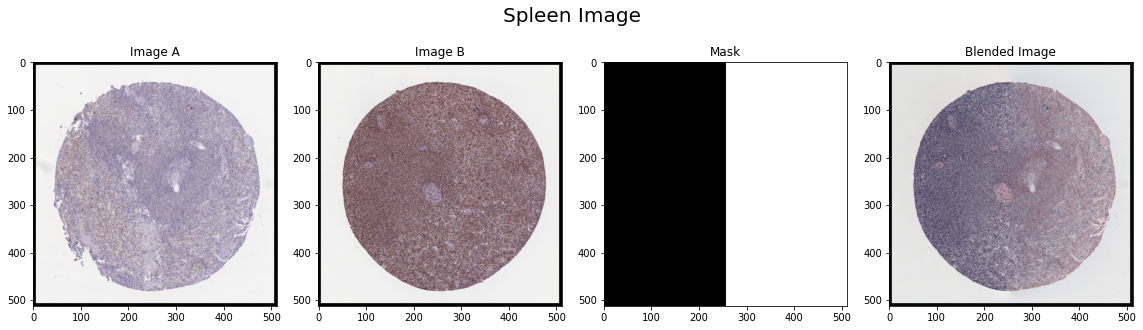

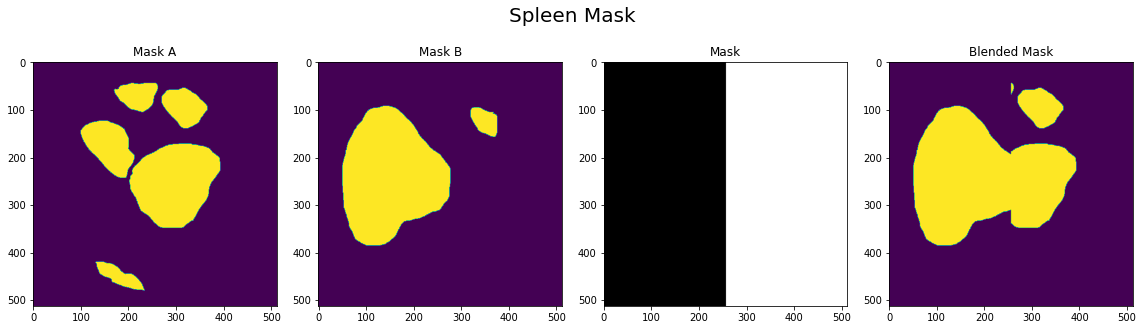

In [16]:
plot_blended_img(img_A, img_B, mask0, 'Spleen Image', 'spleen')
plot_blended_mask(mask_A, mask_B, mask0, 'Spleen Mask', 'spleen')

## Lung

In [17]:
df_organs.style.hide_index().apply(highlight([2]), axis=1)

organ,ids
prostate,"[10044, 10274, 10666, 10912, 10971, 1184, 12233, 12244, 1229, 13483, 13942, 14396, 14407, 1500, 15706, 15732, 16149, 16609, 16659, 1690, 17143, 17187, 17455, 17828, 18422, 19084, 1955, 19569, 20247, 20428, 20955, 21086, 21155, 2174, 22016, 22059, 22995, 23009, 23640, 23828, 23959, 23961, 24194, 24269, 24961, 25430, 26982, 27471, 28318, 28622, 29213, 29223, 29296, 29307, 29809, 30080, 30294, 30355, 30414, 30424, 30765, 31898, 31958, 32009, 32126, 32412, 32741, 3409, 435, 4639, 4658, 4802, 4944, 5287, 5317, 5785, 5932, 5995, 6120, 6390, 6730, 6794, 737, 7397, 7706, 7902, 8227, 8388, 8638, 8842, 9231, 928, 9358]"
spleen,"[10392, 10610, 10703, 10992, 1123, 11448, 11645, 12026, 12466, 12483, 144, 15551, 18792, 19179, 19360, 19377, 19507, 19997, 2079, 20831, 21358, 22236, 2279, 22953, 24833, 25472, 26664, 27781, 27803, 28126, 28657, 28748, 28963, 29143, 29690, 30201, 3054, 3057, 30581, 31290, 31675, 31733, 32231, 3959, 4404, 5583, 6722, 7169, 8116, 8876, 8894, 9407, 9453]"
lung,"[10488, 11064, 11629, 1220, 12452, 12476, 127, 12827, 13189, 14388, 15067, 15124, 15329, 16564, 1731, 1878, 20563, 23252, 24782, 25516, 25945, 26480, 27232, 2793, 28052, 28189, 28429, 29610, 30084, 30394, 30500, 31139, 31571, 31800, 32151, 4301, 4412, 4776, 5086, 5552, 5777, 686, 7359, 8151, 8231, 8343, 9387, 9450]"
kidney,"[10611, 11497, 1157, 12784, 13034, 13260, 14756, 15005, 15192, 15787, 15860, 16163, 16214, 16216, 16362, 164, 16711, 17422, 18121, 18401, 18426, 18449, 18777, 19048, 19533, 20302, 20440, 20478, 20520, 20794, 21021, 21112, 21129, 21195, 21321, 22035, 22133, 22544, 22718, 22741, 23051, 23243, 2344, 23665, 23760, 23880, 24097, 24100, 24222, 2424, 24241, 2447, 24522, 2500, 25620, 26101, 26174, 2668, 27298, 27350, 27468, 27616, 27879, 28262, 28436, 2874, 28823, 28940, 29238, 2943, 30194, 30224, 30250, 30474, 3083, 30876, 31698, 31709, 32325, 32527, 4066, 4265, 4777, 5099, 5102, 6021, 62, 6318, 660, 6807, 7569, 7970, 8502, 9437, 9445, 9470, 9517, 9769, 9791]"
largeintestine,"[10651, 10892, 11662, 1168, 11890, 12174, 12471, 13396, 13507, 14183, 14674, 15499, 15842, 16728, 16890, 17126, 18445, 1850, 18900, 203, 21039, 21501, 21812, 22310, 23094, 25298, 25641, 25689, 26319, 26780, 26886, 2696, 27128, 27340, 27587, 27861, 28045, 28791, 29180, 29424, 29820, 31406, 31727, 31799, 3303, 351, 4062, 4561, 5832, 6121, 6611, 676, 8222, 8402, 8450, 8752, 9777, 9904]"


In [18]:
random.seed(10)
random_lung = random.sample(df_organs.loc[df_organs['organ'] == 'lung'].ids[2], 2)
img_A, mask_A = read_image_mask(data_frame,random_lung[0])
img_B, mask_B = read_image_mask(data_frame,random_lung[1])
img_A.shape, img_B.shape, mask_A.size, mask_B.size

((512, 512, 3), (512, 512, 3), (512, 512), (512, 512))

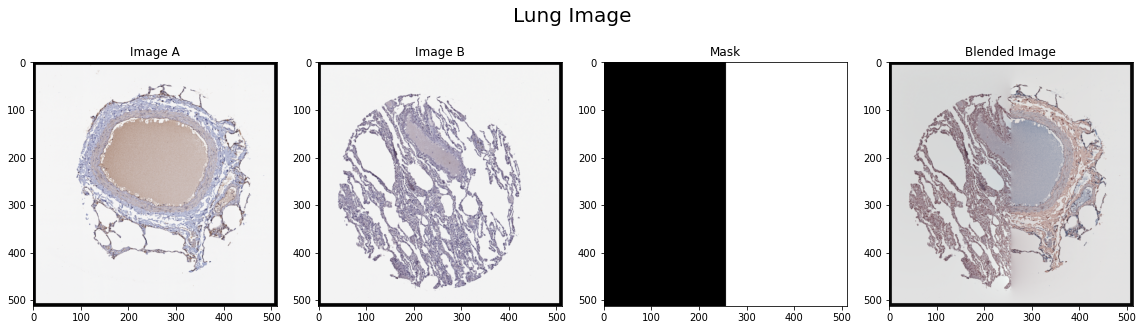

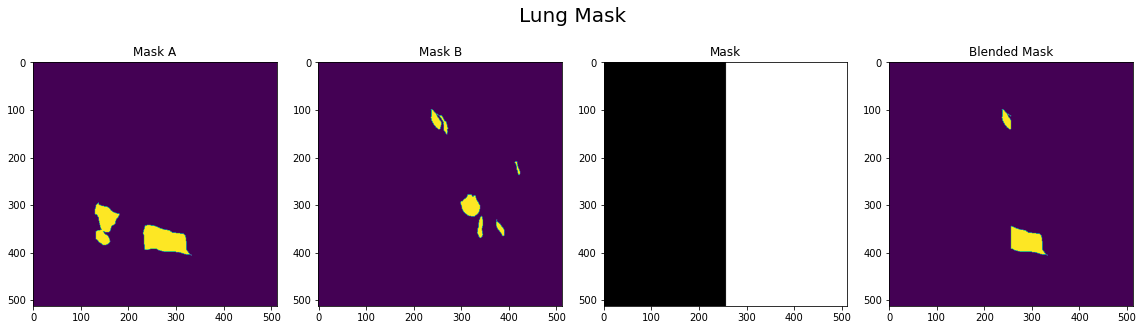

In [19]:
plot_blended_img(img_A, img_B, mask0, 'Lung Image', 'lung')
plot_blended_mask(mask_A, mask_B, mask0, 'Lung Mask', 'lung')

## Kidney

In [20]:
df_organs.style.hide_index().apply(highlight([3]), axis=1)

organ,ids
prostate,"[10044, 10274, 10666, 10912, 10971, 1184, 12233, 12244, 1229, 13483, 13942, 14396, 14407, 1500, 15706, 15732, 16149, 16609, 16659, 1690, 17143, 17187, 17455, 17828, 18422, 19084, 1955, 19569, 20247, 20428, 20955, 21086, 21155, 2174, 22016, 22059, 22995, 23009, 23640, 23828, 23959, 23961, 24194, 24269, 24961, 25430, 26982, 27471, 28318, 28622, 29213, 29223, 29296, 29307, 29809, 30080, 30294, 30355, 30414, 30424, 30765, 31898, 31958, 32009, 32126, 32412, 32741, 3409, 435, 4639, 4658, 4802, 4944, 5287, 5317, 5785, 5932, 5995, 6120, 6390, 6730, 6794, 737, 7397, 7706, 7902, 8227, 8388, 8638, 8842, 9231, 928, 9358]"
spleen,"[10392, 10610, 10703, 10992, 1123, 11448, 11645, 12026, 12466, 12483, 144, 15551, 18792, 19179, 19360, 19377, 19507, 19997, 2079, 20831, 21358, 22236, 2279, 22953, 24833, 25472, 26664, 27781, 27803, 28126, 28657, 28748, 28963, 29143, 29690, 30201, 3054, 3057, 30581, 31290, 31675, 31733, 32231, 3959, 4404, 5583, 6722, 7169, 8116, 8876, 8894, 9407, 9453]"
lung,"[10488, 11064, 11629, 1220, 12452, 12476, 127, 12827, 13189, 14388, 15067, 15124, 15329, 16564, 1731, 1878, 20563, 23252, 24782, 25516, 25945, 26480, 27232, 2793, 28052, 28189, 28429, 29610, 30084, 30394, 30500, 31139, 31571, 31800, 32151, 4301, 4412, 4776, 5086, 5552, 5777, 686, 7359, 8151, 8231, 8343, 9387, 9450]"
kidney,"[10611, 11497, 1157, 12784, 13034, 13260, 14756, 15005, 15192, 15787, 15860, 16163, 16214, 16216, 16362, 164, 16711, 17422, 18121, 18401, 18426, 18449, 18777, 19048, 19533, 20302, 20440, 20478, 20520, 20794, 21021, 21112, 21129, 21195, 21321, 22035, 22133, 22544, 22718, 22741, 23051, 23243, 2344, 23665, 23760, 23880, 24097, 24100, 24222, 2424, 24241, 2447, 24522, 2500, 25620, 26101, 26174, 2668, 27298, 27350, 27468, 27616, 27879, 28262, 28436, 2874, 28823, 28940, 29238, 2943, 30194, 30224, 30250, 30474, 3083, 30876, 31698, 31709, 32325, 32527, 4066, 4265, 4777, 5099, 5102, 6021, 62, 6318, 660, 6807, 7569, 7970, 8502, 9437, 9445, 9470, 9517, 9769, 9791]"
largeintestine,"[10651, 10892, 11662, 1168, 11890, 12174, 12471, 13396, 13507, 14183, 14674, 15499, 15842, 16728, 16890, 17126, 18445, 1850, 18900, 203, 21039, 21501, 21812, 22310, 23094, 25298, 25641, 25689, 26319, 26780, 26886, 2696, 27128, 27340, 27587, 27861, 28045, 28791, 29180, 29424, 29820, 31406, 31727, 31799, 3303, 351, 4062, 4561, 5832, 6121, 6611, 676, 8222, 8402, 8450, 8752, 9777, 9904]"


In [21]:
random.seed(10)
random_kidney = random.sample(df_organs.loc[df_organs['organ'] == 'kidney'].ids[3], 2)
img_A, mask_A = read_image_mask(data_frame,random_kidney[0])
img_B, mask_B = read_image_mask(data_frame,random_kidney[1])
img_A.shape, img_B.shape, mask_A.size, mask_B.size

((512, 512, 3), (512, 512, 3), (512, 512), (512, 512))

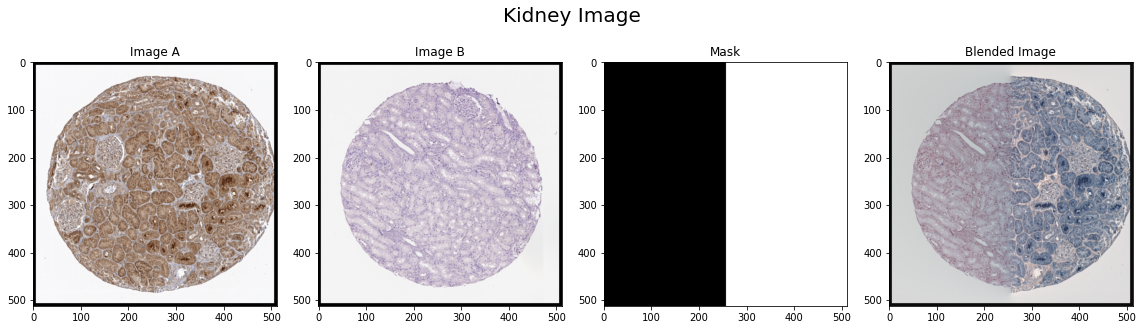

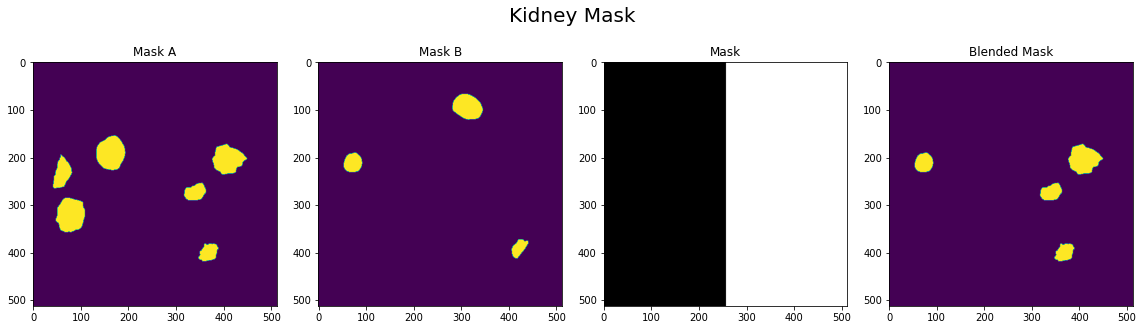

In [22]:
plot_blended_img(img_A, img_B, mask0, 'Kidney Image', 'kidney')
plot_blended_mask(mask_A, mask_B, mask0, 'Kidney Mask', 'kidney')

## Large Intestine

In [23]:
df_organs.style.hide_index().apply(highlight([4]), axis=1)

organ,ids
prostate,"[10044, 10274, 10666, 10912, 10971, 1184, 12233, 12244, 1229, 13483, 13942, 14396, 14407, 1500, 15706, 15732, 16149, 16609, 16659, 1690, 17143, 17187, 17455, 17828, 18422, 19084, 1955, 19569, 20247, 20428, 20955, 21086, 21155, 2174, 22016, 22059, 22995, 23009, 23640, 23828, 23959, 23961, 24194, 24269, 24961, 25430, 26982, 27471, 28318, 28622, 29213, 29223, 29296, 29307, 29809, 30080, 30294, 30355, 30414, 30424, 30765, 31898, 31958, 32009, 32126, 32412, 32741, 3409, 435, 4639, 4658, 4802, 4944, 5287, 5317, 5785, 5932, 5995, 6120, 6390, 6730, 6794, 737, 7397, 7706, 7902, 8227, 8388, 8638, 8842, 9231, 928, 9358]"
spleen,"[10392, 10610, 10703, 10992, 1123, 11448, 11645, 12026, 12466, 12483, 144, 15551, 18792, 19179, 19360, 19377, 19507, 19997, 2079, 20831, 21358, 22236, 2279, 22953, 24833, 25472, 26664, 27781, 27803, 28126, 28657, 28748, 28963, 29143, 29690, 30201, 3054, 3057, 30581, 31290, 31675, 31733, 32231, 3959, 4404, 5583, 6722, 7169, 8116, 8876, 8894, 9407, 9453]"
lung,"[10488, 11064, 11629, 1220, 12452, 12476, 127, 12827, 13189, 14388, 15067, 15124, 15329, 16564, 1731, 1878, 20563, 23252, 24782, 25516, 25945, 26480, 27232, 2793, 28052, 28189, 28429, 29610, 30084, 30394, 30500, 31139, 31571, 31800, 32151, 4301, 4412, 4776, 5086, 5552, 5777, 686, 7359, 8151, 8231, 8343, 9387, 9450]"
kidney,"[10611, 11497, 1157, 12784, 13034, 13260, 14756, 15005, 15192, 15787, 15860, 16163, 16214, 16216, 16362, 164, 16711, 17422, 18121, 18401, 18426, 18449, 18777, 19048, 19533, 20302, 20440, 20478, 20520, 20794, 21021, 21112, 21129, 21195, 21321, 22035, 22133, 22544, 22718, 22741, 23051, 23243, 2344, 23665, 23760, 23880, 24097, 24100, 24222, 2424, 24241, 2447, 24522, 2500, 25620, 26101, 26174, 2668, 27298, 27350, 27468, 27616, 27879, 28262, 28436, 2874, 28823, 28940, 29238, 2943, 30194, 30224, 30250, 30474, 3083, 30876, 31698, 31709, 32325, 32527, 4066, 4265, 4777, 5099, 5102, 6021, 62, 6318, 660, 6807, 7569, 7970, 8502, 9437, 9445, 9470, 9517, 9769, 9791]"
largeintestine,"[10651, 10892, 11662, 1168, 11890, 12174, 12471, 13396, 13507, 14183, 14674, 15499, 15842, 16728, 16890, 17126, 18445, 1850, 18900, 203, 21039, 21501, 21812, 22310, 23094, 25298, 25641, 25689, 26319, 26780, 26886, 2696, 27128, 27340, 27587, 27861, 28045, 28791, 29180, 29424, 29820, 31406, 31727, 31799, 3303, 351, 4062, 4561, 5832, 6121, 6611, 676, 8222, 8402, 8450, 8752, 9777, 9904]"


In [24]:
random.seed(10)
random_largeintestine = random.sample(df_organs.loc[df_organs['organ'] == 'largeintestine'].ids[4], 2)
img_A, mask_A = read_image_mask(data_frame,random_largeintestine[0])
img_B, mask_B = read_image_mask(data_frame,random_largeintestine[1])
img_A.shape, img_B.shape, mask_A.size, mask_B.size

((512, 512, 3), (512, 512, 3), (512, 512), (512, 512))

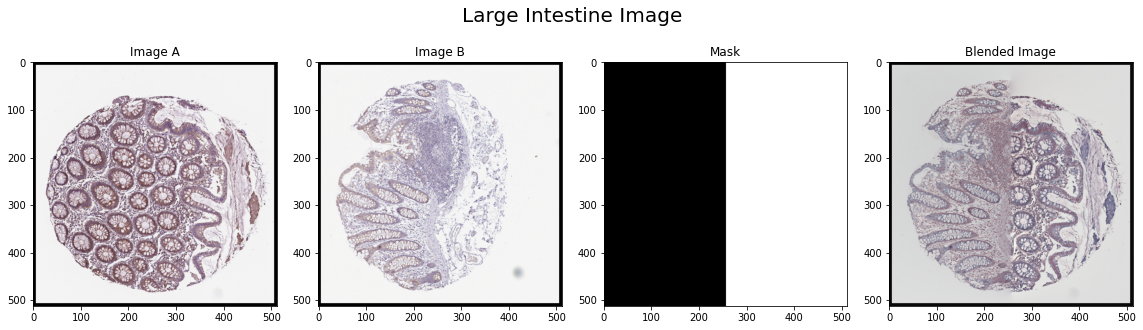

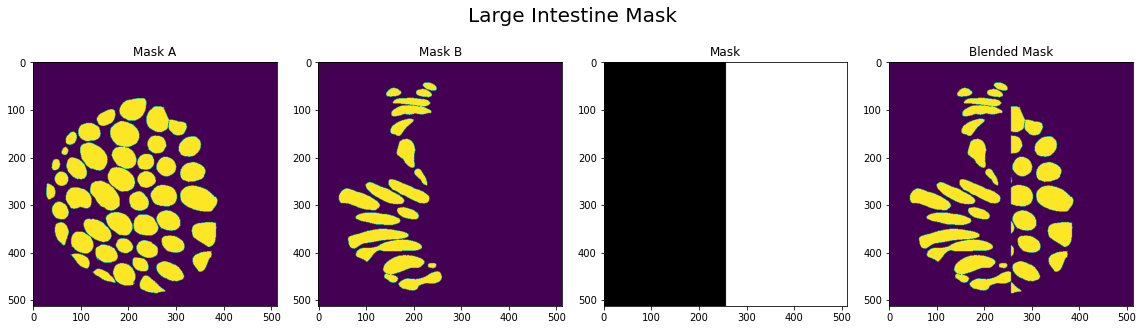

In [25]:
plot_blended_img(img_A, img_B, mask0, 'Large Intestine Image', 'largeintestine')
plot_blended_mask(mask_A, mask_B, mask0, 'Large Intestine Mask', 'largeintestine')

=> These blending images and masks might help to augment the dataset and to balance the respective classes under investigation. 👀